<a href="https://colab.research.google.com/github/muhammmad-al/decentralized-ai-content-recommender/blob/main/centralized_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/content
Cloning into 'decentralized-ai-content-recommender'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 130 (delta 46), reused 57 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (130/130), 12.38 MiB | 5.10 MiB/s, done.
Resolving deltas: 100% (46/46), done.
Updating files: 100% (16/16), done.
/content/decentralized-ai-content-recommender
Starting Centralized Recommender System Training...

Dataset Overview:
Total samples: 15000

Interaction Statistics:
Posts with interactions: 4999
Interaction rate: 33.33%
Average engagement duration: 0.00
Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5644 - auc: 0.6555 - loss: 0.8814 - precision: 0.4122 - recall: 0.7180 - val_accuracy: 0.4046 - val_auc: 0.9151 - val_loss: 0.5617 - val_precision: 0.3559 - val_recall: 0.9987
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6856 - auc: 0.8963 - los

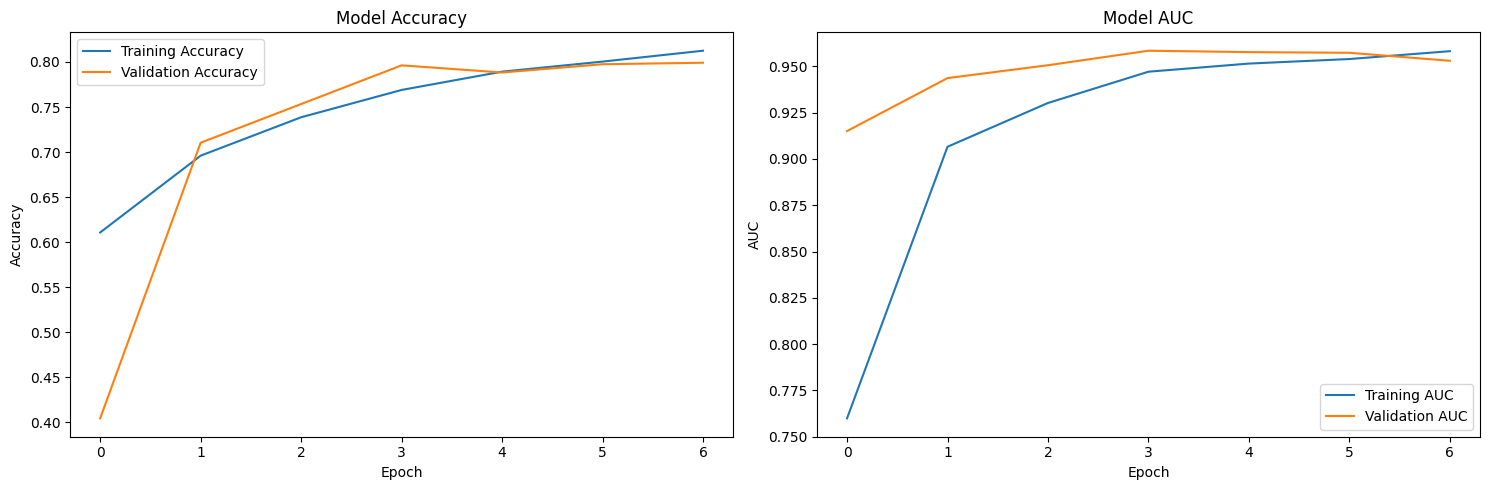

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Final Evaluation:
AUC: 0.9582
Average Precision: 0.9304
Interaction Strength Correlation: 0.7114

Precision-Recall at Different Thresholds:

At threshold 0.3:
Precision: 0.5603
Recall: 0.9890

At threshold 0.5:
Precision: 0.6343
Recall: 0.9680

At threshold 0.7:
Precision: 0.7118
Recall: 0.9310


In [9]:
# Initial Setup and Imports
%cd /content
!rm -rf *  # Remove everything first
!git clone https://github.com/muhammmad-al/decentralized-ai-content-recommender.git
%cd decentralized-ai-content-recommender

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score
)
import seaborn as sns
import logging
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO,
                   format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def preprocess_text(text):
    """Basic text preprocessing"""
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = ' '.join(text.split())
    return text

class CentralizedRecommender:
    def __init__(self):
        self.vectorizer = None
        self.model = None
        self.scaler = StandardScaler()

    def load_data(self):
        """Load and combine all data"""
        # Load content datasets
        datasets = {
            'ai': pd.read_csv('data/raw/reddit_analysis_ai_5000_posts_with_sentiment.csv'),
            'music': pd.read_csv('data/raw/reddit_analysis_music_5000_posts_with_sentiment.csv'),
            'web3': pd.read_csv('data/raw/reddit_analysis_web3_5000_posts_with_sentiment.csv')
        }

        # Load user interactions
        user_interactions = pd.read_csv('data/mock/user_interactions.csv')

        # Process timestamps
        for df in datasets.values():
            df['timestamp'] = pd.to_datetime(df['timestamp'])

        combined_dfs = []
        for category, df in datasets.items():
            # Add interaction features
            category_interactions = user_interactions[user_interactions['category'] == category]
            interaction_features = category_interactions.groupby('content_id').agg({
                'interaction_strength': 'mean',
                'engagement_duration': 'mean',
                'interaction_type': lambda x: x.value_counts().index[0]
            }).reset_index()

            df = pd.merge(
                df,
                interaction_features,
                left_index=True,
                right_on='content_id',
                how='left'
            )

            # Fill missing values
            df['interaction_strength'] = df['interaction_strength'].fillna(0)
            df['engagement_duration'] = df['engagement_duration'].fillna(0)
            df['interaction_type'] = df['interaction_type'].fillna('none')

            combined_dfs.append(df)

        self.df = pd.concat(combined_dfs, ignore_index=True)

        # Feature engineering
        self._engineer_features()

        print("\nDataset Overview:")
        print(f"Total samples: {len(self.df)}")
        print("\nInteraction Statistics:")
        print(f"Posts with interactions: {(self.df['interaction_strength'] > 0).sum()}")
        print(f"Interaction rate: {((self.df['interaction_strength'] > 0).mean() * 100):.2f}%")
        print(f"Average engagement duration: {self.df['engagement_duration'].mean():.2f}")

    def _engineer_features(self):
        """Perform feature engineering on the dataset"""
        # Text features
        self.df['cleaned_title'] = self.df['title'].apply(preprocess_text)
        self.df['cleaned_content'] = self.df['cleaned_text'].apply(preprocess_text)
        self.df['combined_text'] = self.df['cleaned_title'] + ' ' + self.df['cleaned_content']

        # Numerical features
        self.df['score_log'] = np.log1p(self.df['score'])
        self.df['comments_log'] = np.log1p(self.df['num_comments'])
        self.df['text_word_count'] = self.df['combined_text'].str.split().str.len()
        self.df['sentiment_compound'] = (self.df['textblob_sentiment'] + self.df['transformer_score']) / 2
        self.df['sentiment_magnitude'] = abs(self.df['textblob_sentiment'])

        # Scale numerical features
        numerical_cols = ['score_log', 'comments_log', 'text_word_count',
                         'sentiment_compound', 'sentiment_magnitude',
                         'interaction_strength', 'engagement_duration']

        self.df[numerical_cols] = self.scaler.fit_transform(self.df[numerical_cols])

    def prepare_data(self):
        """Prepare features and labels for training"""
        # Text vectorization
        self.vectorizer = TfidfVectorizer(
            max_features=300,
            stop_words='english',
            ngram_range=(1, 1),
            min_df=2,
            max_df=0.95
        )
        X_text = self.vectorizer.fit_transform(self.df['combined_text']).toarray()

        # Numerical features
        numerical_features = [
            'score_log', 'comments_log', 'text_word_count',
            'sentiment_compound', 'sentiment_magnitude'
        ]
        X_numerical = self.df[numerical_features].values

        # Combine features
        self.X = np.hstack([X_text, X_numerical])

        # Create target variable (binary: interacted or not)
        self.y = (self.df['interaction_strength'] > 0).astype(float)

        # Create sample weights based on engagement duration
        self.sample_weights = self.df['engagement_duration'].clip(lower=0.1)
        self.sample_weights = self.sample_weights / self.sample_weights.mean()

        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test, self.weights_train, self.weights_test = train_test_split(
            self.X, self.y, self.sample_weights,
            test_size=0.2,
            stratify=self.y,
            random_state=42
        )

    def create_model(self):
        """Create the neural network model"""
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu',
                                input_shape=(self.X_train.shape[1],),
                                kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])

        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics=[
                'accuracy',
                tf.keras.metrics.AUC(name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
            ]
        )

    def train(self, epochs=20):
        """Train the model"""
        history = self.model.fit(
            self.X_train,
            self.y_train,
            sample_weight=self.weights_train,
            epochs=epochs,
            batch_size=32,
            validation_split=0.2,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_auc',
                    patience=3,
                    restore_best_weights=True
                )
            ],
            verbose=1
        )

        return history

    def evaluate(self):
        """Evaluate model performance"""
        # Get predictions
        predictions = self.model.predict(self.X_test)

        # Calculate metrics
        metrics = {
            'auc': roc_auc_score(self.y_test, predictions),
            'average_precision': average_precision_score(self.y_test, predictions),
            'interaction_strength_correlation': np.corrcoef(
                predictions.flatten(),
                self.df.loc[self.y_test.index, 'interaction_strength']
            )[0, 1]
        }

        # Calculate metrics at different thresholds
        thresholds = [0.3, 0.5, 0.7]
        for threshold in thresholds:
            binary_preds = (predictions > threshold).astype(int)
            metrics[f'precision_at_{threshold}'] = precision_score(
                self.y_test,
                binary_preds
            )
            metrics[f'recall_at_{threshold}'] = recall_score(
                self.y_test,
                binary_preds
            )

        return metrics

    def plot_training_history(self, history):
        """Plot training metrics"""
        plt.figure(figsize=(15, 5))

        # Plot accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot AUC
        plt.subplot(1, 2, 2)
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.title('Model AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def predict(self, new_content_df):
        """Make predictions on new content"""
        # Prepare features
        new_content_df['cleaned_title'] = new_content_df['title'].apply(preprocess_text)
        new_content_df['cleaned_content'] = new_content_df['cleaned_text'].apply(preprocess_text)
        new_content_df['combined_text'] = new_content_df['cleaned_title'] + ' ' + new_content_df['cleaned_content']

        X_text = self.vectorizer.transform(new_content_df['combined_text']).toarray()

        numerical_features = [
            'score_log', 'comments_log', 'text_word_count',
            'sentiment_compound', 'sentiment_magnitude'
        ]
        X_numerical = self.scaler.transform(new_content_df[numerical_features])

        X = np.hstack([X_text, X_numerical])

        # Get predictions
        probabilities = self.model.predict(X)

        # Add predictions to the dataframe
        results_df = new_content_df.copy()
        results_df['interaction_probability'] = probabilities

        # Add confidence levels
        results_df['confidence_level'] = pd.cut(
            results_df['interaction_probability'],
            bins=[0, 0.3, 0.7, 1],
            labels=['low', 'medium', 'high']
        )

        return results_df

def main():
    """Main execution function"""
    print("Starting Centralized Recommender System Training...")

    # Initialize and train recommender
    recommender = CentralizedRecommender()
    recommender.load_data()
    recommender.prepare_data()
    recommender.create_model()

    # Train the model
    history = recommender.train()

    # Plot training metrics
    recommender.plot_training_history(history)

    # Evaluate performance
    metrics = recommender.evaluate()

    # Print final evaluation
    print("\nFinal Evaluation:")
    print("=" * 50)
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"Average Precision: {metrics['average_precision']:.4f}")
    print(f"Interaction Strength Correlation: {metrics['interaction_strength_correlation']:.4f}")

    print("\nPrecision-Recall at Different Thresholds:")
    thresholds = [0.3, 0.5, 0.7]
    for threshold in thresholds:
        print(f"\nAt threshold {threshold}:")
        print(f"Precision: {metrics[f'precision_at_{threshold}']:.4f}")
        print(f"Recall: {metrics[f'recall_at_{threshold}']:.4f}")

    return recommender

if __name__ == "__main__":
    recommender = main()